# Style transfer

## 1. Введение
За основу данного семинара взят ноутбук https://pytorch.org/tutorials/advanced/neural_style_tutorial.html 

В этом ноутбуке мы реализуем алгоритм переноса стиля из статьи [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576).

Перенос стиля (Style Transfer, Neural-Style, Neural-Transfer) – это процесс преобразования стиля исходного изображения к стилю выбранного изображения.

***Основной идеей алгоритма, описанного в ноутбуке, является то, что
признаки, полученные с помощью сверточной нейронной сети, можно использовать
для выделения содержательной и стилевой составляющих изображения.***

На вход алгоритму требуется три изображения:
* input-image – изменяемое входное изображение (обычно берется исходное изображение или белый шум)
* content-image – исходное изображение
* style-image – изображение, стиль которого будет использован


Алгоритм изменяет input-image таким образом, чтобы содержание было похоже на content-image, а стиль – на style-image.

## 2. Формализация идеи

Мы определяем два расстояния (метрики):
* $D_C$ - расстояние между содержанием на изображениях (content distance)
* $D_S$ - расстояние между стилями на изображениях (style distance)

Затем берём изменяемое изображение (input-image) и трансформируем его так, чтобы на результирующем изображении минимизровались оба расстояния.

In [1]:
import copy

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image


%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"

Загружаем изображения

------------------

Загружаем стилевое изображение и изменяемое (content) изображение.

Исходные PIL-картинки содержат значения от 0 до 255, однако при их преобразовании в тензоры значения переходят на отрезок от 0 до 1.

Также изображения должны быть приведены к одинаковым размерам.

***Важно!*** В pytorch значения тензоров должны лежать на отрезке от 0 до 1. Если попробовать применить модель к тензору со значениями от 0 до 255, то в результате применения свёрток (feature maps) не получится корректно выделить содержание и стиль на изображении.

In [2]:
# desired size of the output image; use small size if no gpu available
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),   # scale imported image
    transforms.ToTensor()                  # transform it into a torch tensor
])


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [ ]:
# download pictures
!wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
!wget https://i.ibb.co/ZNv8zXm/photo-2020-08-25-09-24-33.jpg

style_img = image_loader("picasso.jpg")
content_img = image_loader("photo-2020-08-25-09-24-33.jpg")

assert style_img.size() == content_img.size(), \
    "We need to import style and content images of the same size"

Создадим функцию, которая визуализирует изображение, копируя его и переводя обратно в PIL формат.


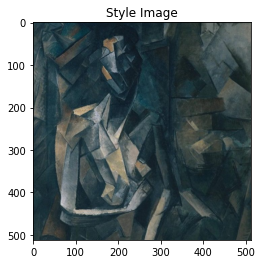

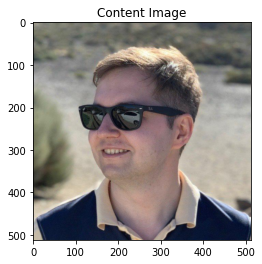

In [4]:
def imshow(tensor, title=None):
    plt.figure()
    image = tensor.cpu().clone()   # we clone the tensor to not do changes on it
    image = image.squeeze(0)       # remove the fake batch dimension
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)               # pause a bit so that plots are updated


imshow(style_img, title="Style Image")
imshow(content_img, title="Content Image")

## 3. Функции потерь

Введем обозначения: X -- input-image, C -- content-image, S -- style-image.

**Content Loss**

Content loss - взвешенный вариант content distance ($D_C$) для каждого свёрточного слоя сети.
* принимает на вход feature maps $F_{XL}$ для изображения $X$ и слоя $L$ сети
* возвращает взвешенное рассстояние $w_{CL}.D_C^L(X,C)$ между изображением $X$ и контентным изображением $C$.

Feature maps контентного изображения ($F_{CL}$) должны быть известны заранее для вычисления контентного расстояния:
$$D_C^L(X,C)=\|F_{XL} - F_{CL}\|^2$$ (для вычисления используем ``nn.MSELoss``).


In [5]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super().__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

**Style Loss**

Модуль Style loss выглядит похожим образом.

Чтобы вычислить style loss, необходимо вычислить матрицу Грама (матрицу скалярных произведений) $G_{XL}$. Матрица Грама - это результат умножения матрицы на её транспонированный вариант. 

В данном случае нам нужна матрица feature maps $F_{XL}$ для слоя $L$. Мы трансформируем матрицу $F_{XL}$, чтобы она имела размерность $K \times N$, где 
* $K$ - число feature maps на слое $L$
* $N$ - длина каждой вытянутой в вектор feature map $F_{XL}^k$.
Обозначим матрицу требуемой размерности $\hat{F}_{XL}$.

**Пояснение:**
например, первая строка матрицы $\hat{F}_{XL}$ соответствует первой feature map $F_{XL}^1$, вытянутой в вектор.

Наконец, мы нормализуем матрицу Грама путем деления каждого элемента на число элементов матрицы. 

**Зачем это нужно?**
Такая нормализация нужна потому, что матрицы $\hat{F}_{XL}$ с большой размерностью $N$ приводят к большим значениям в матрице Грама. Большие значения в свою очередь могут спровоцировать то, что первые сверточные слои (до применения pooling) будут иметь наибольший вклад в процесс градиентного спуска. Но стилевые признаки по большей части содержатся в глубоких слоях нейронной сети, поэтому эта нормализация важна.

In [6]:
def gram_matrix(input: torch.Tensor) -> torch.Tensor:
    batch_size, num_of_fm, h, w = input.size()            # (BS, num of feature maps, f. map height, f.map width)

    features = input.view(batch_size * num_of_fm, h * w)  # resise F_XL into \hat F_XL

    G = torch.matmul(features, features.t())              # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(batch_size * num_of_fm * h * w)

Style loss, аналогично content loss, вычисляется через квадрат расстояния между $G_{XL}$ and $G_{SL}$.




In [7]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## 4. Импортируем модель

Будем использовать предобученную нейронную сеть. Для этой задачи возьмём VGG19.

VGG в имплементации pytorch имеет две части:
* Sequential modules: ``features`` (содержит свёртки и пулинги)
* ``Classifier`` (содержит полносвязные слои). 

Мы будем пользоваться модулем ``features``, так как нам нужны результаты применения свёрток для вычисления контентного и стилевого лоссов.

Так как мы используем предобученную нейронную сеть и дообучать мы её не планируем, то мы ставим сеть в режим применения: ``.eval()``.

In [8]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

VGG сети обучены на нормализованных изображениях с параметрами mean=[0.485, 0.456, 0.406] и std=[0.229, 0.224, 0.225].
Поэтому перед подачей изображения в сеть его необходимо нормализовать таким же образом.



In [9]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can put it in nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them (num_ch, 1, 1) so that they can
        # directly work with image Tensor of shape (BS, num_ch, h * w)).
        self.mean = torch.tensor(mean).clone().view(-1, 1, 1)
        self.std = torch.tensor(std).clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

Теперь мы должны добавить к свёрточной части сети VGG19 стилевой и контентный лосс сразу после свёрточных слоёв.

Для этого необходимо создать новый модуль ``Sequential`` с добавленными в нужные места лоссами.



In [10]:
# desired depth layers to compute style/content losses :
content_layers_default = ["conv_4"]
style_layers_default = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]

def get_style_model_and_losses(
    cnn: nn.Module, 
    normalization_mean: torch.Tensor, 
    normalization_std: torch.Tensor,
    style_img: torch.Tensor, 
    content_img: torch.Tensor,
    content_layers: list[str] = content_layers_default,
    style_layers: list[str] = style_layers_default
) -> tuple[nn.Module, list[torch.Tensor], list[torch.Tensor]]:
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # in order to have an iterable access to content/syle losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{i}"
        elif isinstance(layer, nn.BatchNorm2d):
            name = f"bn_{i}"
        else:
            raise RuntimeError(f"Unrecognized layer: {layer.__class__.__name__}")

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]

    return model, style_losses, content_losses

Теперь выбираем input image. В качестве input image можно использовать, например, исходное (content) изображение или белый шум.



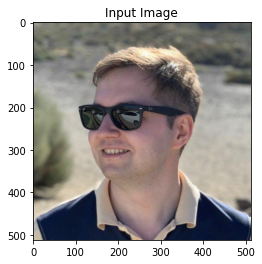

In [11]:
input_img = content_img.clone()

# add the original input image to the figure:
imshow(input_img, title="Input Image")

## 5. Градиентный спуск

Как предложил автор алгоритма, мы будем использовать алгоритм
L-BFGS градиентного спуска. 

В данной версии алгоритма мы обучаем не веса в сети, а исходное изображение, чтобы минимизировать content/style
losses. Для этого используем pytorch ``optim.LBFGS`` и передаем наше изображение (как тензор) в оптимизатор.




In [12]:
def get_input_optimizer(input_img: torch.Tensor) -> torch.optim.Optimizer:
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    
    return optimizer

Наконец, создадим функцию, осуществляющую стилевой перенос.
* на каждой итерации она получает на вход изображение и вычисляет новые значения лоссов (style/content).
* также на каждом шаге с помощью ``backward`` методов динамически вычисляются градиенты функций потерь. 

Также необходимо привести значения тензоров к отрезку $[0;1]$ на каждой итерации.



In [13]:
def run_style_transfer(
    cnn: nn.Module, 
    normalization_mean: torch.Tensor, 
    normalization_std: torch.Tensor,
    style_img: torch.Tensor, 
    content_img: torch.Tensor,
    input_img: torch.Tensor, 
    num_steps: int = 15,
    style_weight: float = 1000000., 
    content_weight: float = 1.
) -> torch.Tensor:
    print("Building the style transfer model...")
    
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, 
        normalization_mean, 
        normalization_std, 
        style_img, 
        content_img
    )
    optimizer = get_input_optimizer(input_img)

    print("Optimizing...")

    style_score_hist = []
    content_score_hist = []
    for step in range(num_steps):
        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = style_weight * sum([s.loss for s in style_losses])
            content_score = content_weight * sum([c.loss for c in content_losses])

            loss = style_score + content_score
            style_score_hist.append(style_score)
            content_score_hist.append(content_score)
            loss.backward()
            
            return loss
        
        # specifics of LBFGS optimizer
        optimizer.step(closure)
        
        if (step) % 5 == 0:
            print(f"Step number: {step + 1}")
            print(f"Style Loss : {style_score_hist[-1].item():.4f} Content Loss: {content_score_hist[-1].item():.4f}")

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Запускаем алгоритм!

In [14]:
output = run_style_transfer(
    cnn, 
    cnn_normalization_mean, 
    cnn_normalization_std,
    style_img,
    content_img, 
    input_img, 
    style_weight=500_000
)

Building the style transfer model...
Optimizing...


/tmp/ipykernel_27330/1293372059.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).clone().view(-1, 1, 1)
/tmp/ipykernel_27330/1293372059.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).clone().view(-1, 1, 1)


Step number: 1
Style Loss : 49.5535 Content Loss: 4.1306
Step number: 6
Style Loss : 13.2302 Content Loss: 3.8957
Step number: 11
Style Loss : 4.1967 Content Loss: 2.7454


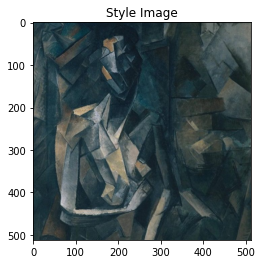

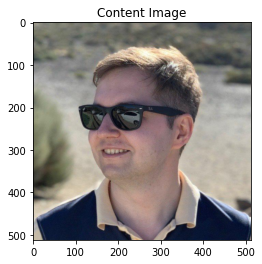

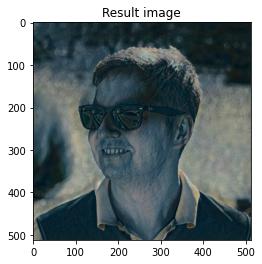

In [15]:
imshow(style_img, title="Style Image")
imshow(content_img, title="Content Image")
imshow(output, title="Result image")

## 6. Задания

#### Задание 1. 

Мы запустили алгоритм, используя в качестве `input_image` исходное изображение (`content_image`). Попробуйте в качестве `input_image` взять белый шум. Визуализируйте результат.

In [ ]:
# your code here (you can change an existing code)

#### Задание 2.
Загрузите другую стилевую картинку (например, "звездную ночь" Ван Гога или любую другую), не забудьте привести её к тем же размерам, что и картинка с содержанием.

Примените новый стиль к изображению. Нравится ли вам результат?

In [ ]:
# your code here (you can change an existing code)

#### Задание 3.
Поэкспериментируйте с коэффициентами при `style_loss` и `content_loss` (по дефолту используются значения `style_weight=1000000, content_weight=1`).

Выведите на экран итоговые изображения для различных по порядку `style_weight` (используйте значения весов в диапазоне от 0 до 1).

In [ ]:
# your code here

#### Задание 4.
Для вычисления итогового `style_loss` мы суммируем `style_loss` по первым пяти свёрточным слоям, то есть каждый слой (из первых пяти) имеет одинаковый вклад в итоговый style_loss. Но можно вычислять итоговый `style_loss`, суммируя `style_loss`'ы по слоям с весами. 

Создайте список весов `style_weights` и запишите туда пять весов, которые по вашему мнению дают наибольшие артефакты стиля. Измените вычисление `style_loss` в процедуре `run_style_transfer`, домножая `style_loss` с каждого слоя на соответствующий вес. 

Проведите эксперименты для:
* вашего массива `style_weights`
* `style_weights = [1, 0, 0, 0, 0]`
* `style_weights = [0, 0, 0, 0, 1]`

Какие выводы можно сделать из этих экспериментов?

In [ ]:
# your code here

#### Задание 5.
Описанный в ноутбуке алгоритм работает достаточно медленно, особенно на изображениях большого размера. Как можно модифицировать алгоритм, чтобы снизить число обучаемых параметров?

In [ ]:
# your answer here